# NBA shots 2023
### Decision Tree model

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
df = pd.read_csv('player_shots_final.csv', index_col=0)
df = df.copy()

In [5]:
df = df.drop(['date'], axis=1, )
df[['result','lead','color','Player_Name']] = df[['result','lead','color','Player_Name']].astype('category')

In [6]:
# Mover las potenciales etiquetas al final
df = df[[col for col in df.columns if col != 'color'] + ['color']]
df = df[[col for col in df.columns if col != 'result'] + ['result']]

In [7]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Codificar datos categoricos
# No hace falta crear dummies pq solo hay 2 categorias
from sklearn.preprocessing import LabelEncoder

labelencoder_X_1 = LabelEncoder()
X[:, 6] = labelencoder_X_1.fit_transform(X[:, 6])
X[:, 9] = labelencoder_X_1.fit_transform(X[:, 9])
X[:, 12] = labelencoder_X_1.fit_transform(X[:, 12])

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.4, random_state=0, shuffle=False)


X_test, X_val, y_test, y_val = train_test_split(X_test,y_test,
                                                    test_size=0.5, random_state=0, shuffle=False)

In [9]:
# Escalar var para hacer PCA
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_val = sc_X.transform(X_val)
X_test = sc_X.transform(X_test)

In [10]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 4)
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.29309798 0.17701009 0.14217011 0.08563215]


## Modelo de prubea sin ajustar parametros
#### Hay overfitting

In [37]:
# Ajustar model y predecir
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(criterion = "entropy", random_state = 0)
classifier.fit(X_train, y_train)
y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)

In [38]:
# Elaborar matriz de confusion: comparar la y con la prediccion
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(y_train, y_train_pred)
cm_val = confusion_matrix(y_val, y_val_pred)

# Calculamos el f1-score para train y val sets
from sklearn.metrics import f1_score
f1_train = f1_score(y_train, y_train_pred, pos_label=True)
f1_val = f1_score(y_val, y_val_pred, pos_label=True)

In [39]:
print(f1_train)
print(f1_val)

1.0
0.3055555555555555


In [40]:
# Predecir con test_set
y_test_pred = classifier.predict(X_test)

cm_test = confusion_matrix(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, pos_label=True)
print(f'f1-score test: {f1_test}')

f1-score test: 0.40740740740740744


## GridSearch para encontrar los mejores parámetros

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_depth': [3,4,5,6], 'max_leaf_nodes': [7,8,9,10], 'min_samples_leaf': [1,2]}
  ]

ad_clf = DecisionTreeClassifier(criterion='entropy', random_state=0) 
                        

grid_search = GridSearchCV(ad_clf, param_grid, cv=5,  
                           scoring='f1_weighted', return_train_score=True)  

grid_search.fit(X_train, y_train) 

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=0),
             param_grid=[{'max_depth': [3, 4, 5, 6],
                          'max_leaf_nodes': [7, 8, 9, 10],
                          'min_samples_leaf': [1, 2]}],
             return_train_score=True, scoring='f1_weighted')

In [16]:
# Maejores parámetros
grid_search.best_params_

{'max_depth': 6, 'max_leaf_nodes': 10, 'min_samples_leaf': 1}

Mejores resultados FIRST run: {'max_depth': 4, 'max_leaf_nodes': 8, 'min_samples_leaf': 1}
Mejores resultados SECOND run: {'max_depth': 6, 'max_leaf_nodes': 10, 'min_samples_leaf': 1}

## Mejor modelo

In [19]:
ad_classifier = grid_search.best_estimator_

In [24]:
# Predecir train set
y_train_pred2 = ad_classifier.predict(X_train)

from sklearn.metrics import f1_score
f1_train2 = f1_score(y_train_pred2, y_train, average='weighted')
print(f1_train2)

0.8045388304838896


In [27]:
# Predecir validation set
y_val_pred2 = ad_classifier.predict(X_val)
f1_val2 = f1_score(y_val_pred2, y_val, average='weighted')
print(f1_val2)

0.7149234852938555


In [28]:
# Predecir con test set
y_test_pred2 = ad_classifier.predict(X_test)
f1_test2 = f1_score(y_test_pred2, y_test, average='weighted')
print(f1_test2)

0.7268128161888702


In [31]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix

cm_test2 = confusion_matrix(y_test, y_test_pred2)
print(cm_test2)

[[290  81]
 [ 81 141]]


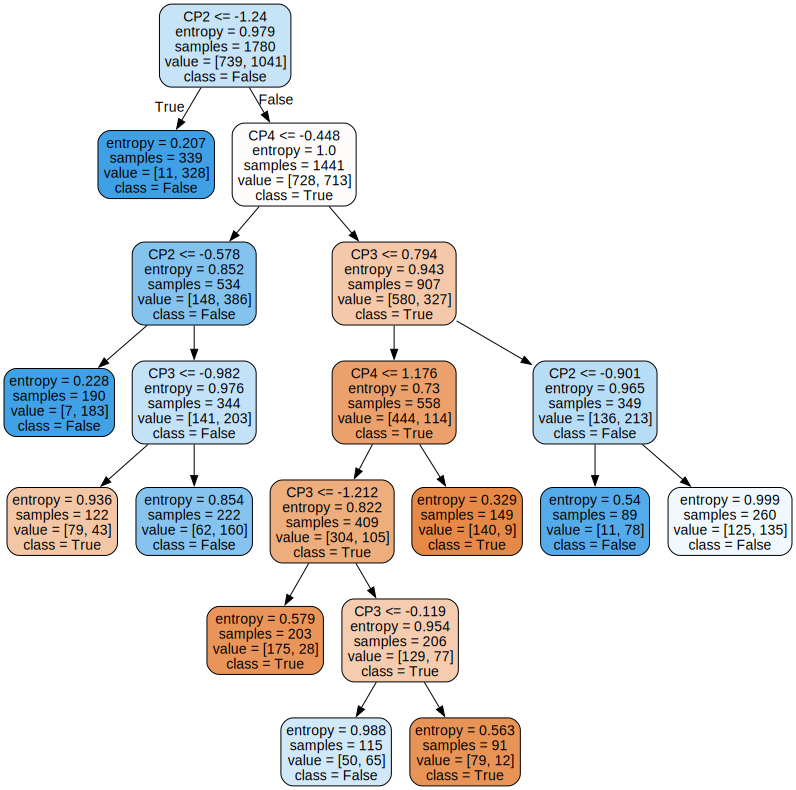

In [29]:
from graphviz import Source
from sklearn.tree import export_graphviz
import os

feature_names = ['CP1','CP2','CP3','CP4']

export_graphviz(
        ad_classifier,
        out_file="player_shots_final.csv",
        feature_names=feature_names,
        class_names=["True", "False"],
        rounded=True,
        filled=True
    )

Source.from_file("player_shots_final.csv")

### Alternativa con los primeros parámetros encontrados
#### Salen peores resultados

In [33]:
from sklearn.tree import DecisionTreeClassifier

classifier3 = DecisionTreeClassifier(criterion = "entropy", random_state = 0, max_depth=4, max_leaf_nodes=8, min_samples_leaf=1)
classifier3.fit(X_train, y_train)

# entrenamiento
y_train_pred3 = classifier3.predict(X_train)
f1_train3 = f1_score(y_train_pred3, y_train, average='weighted')
print(f1_train3)

# validacion
y_val_pred3 = classifier3.predict(X_val)
f1_val3 = f1_score(y_val_pred3, y_val, average='weighted')
print(f1_val3)

0.7919185301566468
0.6986984740537782


In [36]:
y_test_pred3 = classifier3.predict(X_test)
f1_test3 = f1_score(y_test_pred3, y_test, average='weighted')
print(f1_test3)

0.6972185266377893
